In [1]:
import csv
import requests
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
import math

### Request Allocatable GPU to calculate waiting time

In [72]:
# Request as Apr 29th, 2019. Change the offset days if required later.
# Time is [Mar 31st, 2019 18:20:53 GMT - Apr 11th, 2019 21:47:45 GMT]

# Three reasons for such time range:
# 1. Prometheus halts frequently, it is hard to find a longer continuous time series
# 2. New GPU nodes come in periodically
# 3. Pandas Dataframe can't handle more columns of time series data.

address = "https://prometheus.nautilus.optiputer.net"
query = 'kube_node_status_allocatable{resource="nvidia_com_gpu"}[10d] offset 18d'
response = requests.get('{0}/api/v1/query'.format(address), params={'query': query})
results = response.json()['data']['result']

In [282]:
# Save all time series
with open('AllocGPU_ts.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for result in results:
        node = result['metric'].get('node')
        line = [node]
        for value in result['values']:
            # print (value)
            # import pdb; pdb.set_trace()
            line.append(value)
        writer.writerow(line)

In [283]:
# Save only number of GPUs
with open('Allocatable_GPU_number.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for result in results:
        node = result['metric'].get('node')
        line = [node]
        for value in result['values']:
            # print (value)
            # import pdb; pdb.set_trace()
            line.append(value[1])
        writer.writerow(line)

In [295]:
dataset = pd.read_csv('./Allocatable_GPU_number.csv', header=None, error_bad_lines=False, engine='python', skiprows=990)
# print ("The allocatable GPU time series has {0} time stamps".format(dataset.shape[1]))

The allocatable GPU time series has 46153 time stamps


In [162]:
# Average Dataset
df_no_node = dataset.drop(0, axis=1)
series_mean = df_no_node.mean(axis=0)

# Normalize Dataset
diff = (series_mean.max() + series_mean.min())/2
# print (diff)
series_mean_normalized = series_mean - diff
smn_8 = np.floor(series_mean_normalized * (2 / series_mean_normalized.max()) + 6)
# print (smn_8)

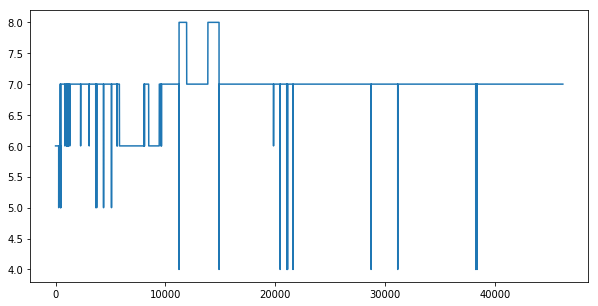

In [164]:
fig = plt.figure(figsize=[10,5])
plt.plot(smn_8)

In [260]:
def calculate_waiting_time(series):
    
    with open('waiting_time.csv', 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames = range(1,9))
        writer.writeheader()
        # Because of dropping the node column, index starts at 1
        for index in range(1, len(series) + 1):
            line_dict = {}

            # initialize next_index as current index
            next_index = index + 1

            for gpu_num in range(1, 9):
                if gpu_num <= series[index]:
                    line_dict[gpu_num] = 0
                else:
                    # Searching forward for waiting time
                    for following_index in range(next_index, len(series) + 1):
                        
                        # cache following_index to efficiently search from where left off
                        next_index = following_index
                        if gpu_num <= series[following_index]:
                            line_dict[gpu_num] = following_index - index
                            #import pdb; pdb.set_trace();
                            break

                    if (gpu_num not in line_dict):
                        # If gpu_num can't be deploy in this time range, set to rightmost time stamp
                        line_dict[gpu_num] = len(series) - index
            # import pdb; pdb.set_trace();
            writer.writerow(line_dict)

In [262]:
calculate_waiting_time(smn_8)

In [23]:
wait_df = pd.read_csv('./waiting_time.csv')

In [4]:
# Upper bound of waiting time
for n in range(6):
    # sampling frequency = 60 secs
    print ("{0} GPU is required to wait up to {1} minutes".format(n + 1, wait_df.iloc[:, n].max() * 60 / 60))
for n in range(6, 8):
    # sampling frequency = 10 secs
    print ("{0} GPU is required to wait up to {1} minutes".format(n + 1, round(wait_df.iloc[:, n].max() * 10 / 60)))

1 GPU is required to wait up to 0.0 minutes
2 GPU is required to wait up to 0.0 minutes
3 GPU is required to wait up to 0.0 minutes
4 GPU is required to wait up to 0.0 minutes
5 GPU is required to wait up to 6.0 minutes
6 GPU is required to wait up to 16.0 minutes
7 GPU is required to wait up to 371.0 minutes
8 GPU is required to wait up to 5213.0 minutes


In [37]:
wait_df = pd.read_csv('./waiting_time.csv')
wait_df.iloc[:, 0:6] = np.float64(wait_df.iloc[:, 0:6])
wait_df.iloc[:, 6:8] = np.ceil(wait_df.iloc[:, 6:8] * 10)
wait_df.tail(100)
# with open ("wait_time_minute.csv", 'w', newline='') as f:
wait_df.to_csv("./wait_time_seconds.csv", index=False)    

### We have two candidates here for additional wait time - average / upper bound


In [43]:
print ("GPU 6 Average Waiting time is {0}".format(wait_df[wait_df['6']!=0].mean()[5]))
print ("GPU 6 Std Waiting time is {0}".format(wait_df[wait_df['6']!=0].std()[5]))
print ("GPU 8 Average Waiting time is {0}".format(wait_df.mean()[7]/60))
print ("GPU 8 Std Waiting time is {0}".format(wait_df.std()[7]/60))

GPU 6 Average Waiting time is 3.7564102564102564
GPU 6 Std Waiting time is 3.423319181600543
GPU 8 Average Waiting time is 2001.112100595135
GPU 8 Std Waiting time is 1555.7793056685186


In [571]:
def plot_cdf(num, nonzero=False):
    if nonzero:
        data = wait_df[wait_df[str(num)]!=0][str(num)]
    else:
        data = wait_df[str(num)]

    sample_size = len(data)
    mean_data = round(data.mean(), 3)
    std_data = round(data.std(), 3)
    print ("=======GPU {}=======".format(num))
    print ("Mean : {}".format(mean_data))
    print ("Stdev : {}".format(std_data))
    print ("==============")
    
    # An "interface" to matplotlib.axes.Axes.hist() method

    _fig, ax = plt.subplots()

    _n, _bins, _patches = ax.hist(x=data, color='#0932ba', bins = 100,
                                alpha=0.7, rwidth=0.85, histtype="step", cumulative=True, 
                                label="empirical CDF", density=True)

    norm_dist_y = np.random.normal(mean_data, std_data, sample_size)

    _n, _bins, _patches = ax.hist(x=norm_dist_y, bins=int(sample_size/2), color='#FF5733',
                                alpha=0.7, rwidth=0.85, histtype="step", cumulative=True, 
                                label="artificial CDF", density=True)

    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Wait time (secs)')
    plt.ylabel('Probability Density')
    ax.legend(loc='upper left')

=======GPU 6=======
Mean : 3.756
Stdev : 3.423
=======GPU 7=======
Mean : 788.741
Stdev : 650.543
=======GPU 8=======
Mean : 12468.655
Stdev : 9204.812


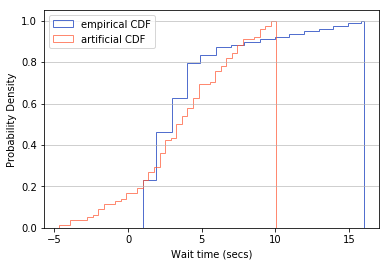

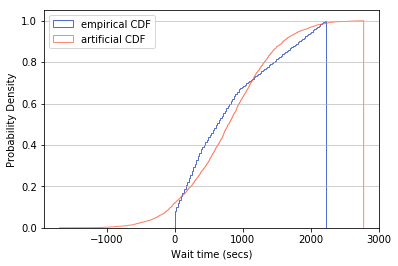

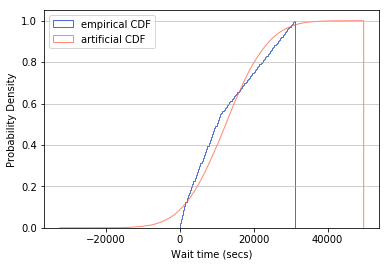

In [572]:
plot_cdf(6, True)
plot_cdf(7, True)
plot_cdf(8, True)

In [530]:
def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)

In [564]:
data = wait_df[wait_df['7']!=0]['7']

data_sorted = sorted(data)

len(data_sorted)

3825

In [566]:
def q_99_boundary(data):
    sample_size = len(data)
    total = 0
    data = sorted(data)
    result = []
    for i in range(sample_size + 1):
        total += nCr(sample_size, sample_size - i)*(0.99**(sample_size - i))*((1-0.99)**i)
        if total >= 0.025:
            print ("total : {0}".format(total))
            print ("U : {0}".format(i))
            print ("Uth largest number : {0}".format(data[i]))
            result.append(data[i])
        if total >= 0.975:
            print ("total : {0}".format(total))
            print ("L : {0}".format(i))
            print ("Lth largest number : {0}".format(data[i]))
            result.append(data[i])
            break

    return result

In [568]:
data = wait_df[wait_df['7']!=0]['7']
q_99_boundary(data)

total : 0.03506094962838405
U : 27
Uth largest number : 1
total : 0.05140469662537525
U : 28
Uth largest number : 1
total : 0.07301988553083524
U : 29
Uth largest number : 1
total : 0.10064657141808314
U : 30
Uth largest number : 1
total : 0.13480860235392733
U : 31
Uth largest number : 1
total : 0.17572108510979634
U : 32
Uth largest number : 1
total : 0.22322064038773062
U : 33
Uth largest number : 1
total : 0.2767317258345301
U : 34
Uth largest number : 1
total : 0.3352773318745927
U : 35
Uth largest number : 1
total : 0.3975354258397547
U : 36
Uth largest number : 1
total : 0.46193507586268645
U : 37
Uth largest number : 1
total : 0.5267798058698278
U : 38
Uth largest number : 1
total : 0.590381720538837
U : 39
Uth largest number : 1
total : 0.6511890056239049
U : 40
Uth largest number : 1
total : 0.7078915368007914
U : 41
Uth largest number : 1
total : 0.7594938403056829
U : 42
Uth largest number : 1
total : 0.805350432779022
U : 43
Uth largest number : 1
total : 0.845164398053165

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]

#### Without assuming a specific distribution, one can say that if the customer waits 
#### [Upper bound] days, the probability that his/her request is still pending is <= 0.01 (99 percentile)

0.006
0.208


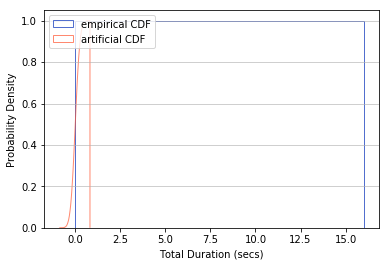

In [515]:
data = wait_df['6']

sample_size = len(data)
mean_data = round(data.mean(), 3)
std_data = round(data.std(), 3)

print (mean_data)
print (std_data)

# An "interface" to matplotlib.axes.Axes.hist() method

_fig, ax = plt.subplots()

# _n, _bins, _patches = ax.hist(x=data, color='#0504aa', bins = 100,
#                             alpha=0.7, rwidth=0.85, histtype="bar", density=True, 
#                             label="PDF")

_n, _bins, _patches = ax.hist(x=data, color='#0932ba', bins = 100,
                            alpha=0.7, rwidth=0.85, histtype="step", cumulative=True, 
                            label="empirical CDF", density=True)

norm_dist_y = np.random.normal(mean_data, std_data, sample_size)

_n, _bins, _patches = ax.hist(x=norm_dist_y, bins=int(sample_size/2), color='#FF5733',
                            alpha=0.7, rwidth=0.85, histtype="step", cumulative=True, 
                            label="artificial CDF", density=True)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Total Duration (secs)')
plt.ylabel('Probability Density')
ax.legend(loc='upper left')
#plt.title('Histogram - Sync Celery, Sync Lambda, Invocation = 100\n' + metrics, fontsize=10)

#maxfreq = n.max()
## Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

#plt.xlim(0,400)

plt.show() 

### Request GPU request to calculate arrival rate

In [279]:
request_query = 'kube_pod_container_resource_requests{resource="nvidia_com_gpu"} [10d] offset 18d'
request_response = requests.get('{0}/api/v1/query'.format(address), params={'query': request_query})
request_results = request_response.json()['data']['result']

In [291]:
len(request_results)

11267

In [366]:
# Calculate arrival rate
request_dict = {}
for result in request_results:
    GPU_num = int(result['values'][0][1])
    curr_num = request_dict.setdefault(GPU_num, 1)
    request_dict[GPU_num] = curr_num + 1
print (request_dict)

for n in range(9):
    if n in request_dict:
        # request per minute
        arrival_rate = request_dict[n] / (10 * 24 * 60)
        print ("The arrival rate of {0} GPU request is {1} per minute".format(n, arrival_rate))

{1: 7899, 0: 507, 2: 1531, 4: 992, 8: 121, 6: 114, 3: 110}
The arrival rate of 0 GPU request is 0.035208333333333335 per minute
The arrival rate of 1 GPU request is 0.5485416666666667 per minute
The arrival rate of 2 GPU request is 0.10631944444444444 per minute
The arrival rate of 3 GPU request is 0.007638888888888889 per minute
The arrival rate of 4 GPU request is 0.06888888888888889 per minute
The arrival rate of 6 GPU request is 0.007916666666666667 per minute
The arrival rate of 8 GPU request is 0.008402777777777778 per minute


### Calculate Container CPU usage seconds as a proxy of duration

In [328]:
cpu_usage_query = 'container_cpu_usage_seconds_total[1d] offset 20d'
cpu_usage_response = requests.get('{0}/api/v1/query'.format(address), params={'query': cpu_usage_query})
cpu_usage_results = cpu_usage_response.json()['data']['result']

In [336]:
# Save cpu storage 
# Count the average duration of pods

with open('CPU_Usage_ts.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for result in cpu_usage_results:
        node = result['metric'].get('pod_name')
        line = [node]
        for value in result['values']:
            # print (value)
            # import pdb; pdb.set_trace()
            line.append(value)
        writer.writerow(line)

In [339]:
cpu_usage_df = pd.read_csv("./CPU_Usage_ts.csv", header=None, error_bad_lines=False, engine='python')

In [340]:
cpu_usage_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880
0,rook-ceph-osd-186-5c68864d99-9wm4c,"[1554966289.221, '0.027227608']","[1554966319.221, '0.027227608']","[1554966349.221, '0.027227608']","[1554966379.221, '0.027227608']","[1554966409.221, '0.027227608']","[1554966439.221, '0.027227608']","[1554966469.221, '0.027227608']","[1554966499.221, '0.027227608']","[1554966529.221, '0.027227608']",...,"[1555052389.221, '0.027227608']","[1555052419.221, '0.027227608']","[1555052449.221, '0.027227608']","[1555052479.221, '0.027227608']","[1555052509.221, '0.027227608']","[1555052539.221, '0.027227608']","[1555052569.221, '0.027227608']","[1555052599.221, '0.027227608']","[1555052629.221, '0.027227608']","[1555052659.221, '0.027227608']"
1,kube-proxy-jq5k6,"[1554966290.215, '0.015732206']","[1554966320.215, '0.015732206']","[1554966350.215, '0.015732206']","[1554966380.215, '0.015732206']","[1554966410.215, '0.015732206']","[1554966440.215, '0.015732206']","[1554966470.215, '0.015732206']","[1554966500.215, '0.015732206']","[1554966530.215, '0.015732206']",...,"[1555052390.215, '0.015732206']","[1555052420.215, '0.015732206']","[1555052450.215, '0.015732206']","[1555052480.215, '0.015732206']","[1555052510.215, '0.015732206']","[1555052540.215, '0.015732206']","[1555052570.215, '0.015732206']","[1555052600.215, '0.015732206']","[1555052630.215, '0.015732206']","[1555052660.215, '0.015732206']"
2,ipmi-mon-pz4nq,"[1554966272.877, '0.014872137']","[1554966302.877, '0.014872137']","[1554966332.877, '0.014872137']","[1554966362.877, '0.014872137']","[1554966392.877, '0.014872137']","[1554966422.877, '0.014872137']","[1554966452.877, '0.014872137']","[1554966482.877, '0.014872137']","[1554966512.877, '0.014872137']",...,None,None,None,None,None,None,None,None,None,None
3,ipmi-mon-pz4nq,"[1555019372.877, '0.016098408']","[1555019402.877, '0.016098408']","[1555019432.877, '0.016098408']","[1555019462.877, '0.016098408']","[1555019492.877, '0.016098408']","[1555019522.877, '0.016098408']","[1555019552.877, '0.016098408']","[1555019582.877, '0.016098408']","[1555019612.877, '0.016098408']",...,None,None,None,None,None,None,None,None,None,None
4,rook-ceph-mon-dn-7dc656887-df4tk,"[1555052154.477, '0.040796']","[1555052184.477, '0.040796']","[1555052214.477, '0.040796']","[1555052244.477, '0.040796']","[1555052274.477, '0.040796']","[1555052304.477, '0.040796']","[1555052334.477, '0.040796']","[1555052364.477, '0.040796']","[1555052394.477, '0.040796']",...,None,None,None,None,None,None,None,None,None,None
5,rook-ceph-osd-134-57b7b8c944-w77qf,"[1554966290.215, '0.023590133']","[1554966320.215, '0.023590133']","[1554966350.215, '0.023590133']","[1554966380.215, '0.023590133']","[1554966410.215, '0.023590133']","[1554966440.215, '0.023590133']","[1554966470.215, '0.023590133']","[1554966500.215, '0.023590133']","[1554966530.215, '0.023590133']",...,"[1555052390.215, '0.023590133']","[1555052420.215, '0.023590133']","[1555052450.215, '0.023590133']","[1555052480.215, '0.023590133']","[1555052510.215, '0.023590133']","[1555052540.215, '0.023590133']","[1555052570.215, '0.023590133']","[1555052600.215, '0.023590133']","[1555052630.215, '0.023590133']","[1555052660.215, '0.023590133']"
6,kube-proxy-vsld6,"[1554966283.062, '0.010845992']","[1554966313.062, '0.010845992']","[1554966343.062, '0.010845992']","[1554966373.062, '0.010845992']","[1554966403.062, '0.010845992']","[1554966433.062, '0.010845992']","[1554966463.062, '0.010845992']","[1554966493.062, '0.010845992']","[1554966523.062, '0.010845992']",...,"[1555052413.062, '0.010845992']","[1555052443.062, '0.010845992']","[1555052473.062, '0.010845992']","[1555052503.062, '0.010845992']","[1555052533.062, '0.010845992']","[1555052563.062, '0.010845992']","[1555052593.062, '0.010845992']","[1555052623.062, '0.010845992']","[1555052653.062, '0.010845992']",None
7,rook-ceph-osd-187-7f55b574bb-29mqh,"[1554966289.221, '0.02756364']","[1554966319.221, '0.02756364']","[1554966349.221,

In [374]:
# Calculate average duration of pod
durations = []
for index, row in cpu_usage_df.iterrows():
    start_ts = ast.literal_eval(row.iloc[1])[0]

    # Search for the last timestamp
    for ts in reversed(row):
        # import pdb; pdb.set_trace();
        if ts:
            end_ts = ast.literal_eval(ts)[0]
            break
    # Exclude the pod longer than a day (23.99 hrs)
    if end_ts - start_ts != 86370:
        durations.append(end_ts - start_ts)

average_duration = pd.Series(durations).mean()
std_duration = pd.Series(durations).std()
print (average_duration)
print (std_duration)

28153.6861974
26866.2760925


#### Average Duration: 55415.710287 seconds / 15.39 hours
#### Standard Deviation: 35038.4642484 seconds / 9.73 hours


### M/M/c/inf/inf

### P0 = (1 + rho + rho^2 / 2*(1 - rho/c))^(-1)

### Lq = (rho^(c+1) / (c-1)!*(c-rho)^2) * P0

lambda - request rate

miu - Average Processing time

rho - Utilization factor = lambda / miu

#### Queueing theory is not a good candidate for GPU wait time prediction, because the C servers is hard to decide.

In [573]:
wait_time_dict = {}
total_gpu = 327
count = 1

# Average processing time in minutes
ave_proc_time =  55415.710287 / 60 

# Standard Deviation in minutes
std_proc_time = 35038.4642484 / 60

for gpu_num in range(1, 9):
    if gpu_num in request_dict:
        request_rate = request_dict[gpu_num] / (10 * 24 * 60)
        u_factor = request_rate / ave_proc_time

        P0 = (1 + u_factor + u_factor**2 / 2 * (1 - u_factor/count))**(-1)
        # import pdb; pdb.set_trace();
        wait_time_dict[gpu_num] = P0 * (u_factor**(count + 1) / (math.factorial(count - 1) * ((count - u_factor)**2)))
        
print (wait_time_dict)

{1: 3.529506820236438e-07, 2: 1.3252935646994997e-08, 3: 6.840701981747619e-11, 4: 5.563747960091978e-09, 6: 7.34725534653555e-11, 8: 8.27725624399987e-11}
